### Курсовой проект

#### Постановка задачи:
Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

##### Целевая переменная
Credit Default - факт невыполнения кредитных обязательств

##### Метрика качества
F1-score

##### Требования к решению
Целевая метрика: F1 > 0.5

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Этап 1. Предобработка тренировочных данных
- Загрузка данных
- Обзор тренировочного и тестового датасета

#### Анализ тренировочного датасета
- Анализ количественных переменных
- Анализ категориальных переменных
- Добавление новых переменных

#### Импорт модулей, библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from sklearn.metrics import f1_score


import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

pd.options.display.max_columns=100

#### Определение костант

In [2]:
PATH_TRAIN_DATA = 'course_project_train.csv'
PATH_TEST_DATA = 'course_project_test.csv'

#### Определение ф-ций

In [3]:
# Построение гистограммы и графика плотности распределения значений признака.
# Есть возможность установки логарифмического масштаба по оси ординат и выведения на график среднего значения,
# медианы и моды.
def plot_hist_n_kde(feature,feature_name,hist_bins=50,x_log=False,y_log=False,mmm='000'):
    rcParams['font.size'] = 8
    plt.figure(figsize=(12,5))

    plt.subplot(121)
    feature.hist(bins=hist_bins)
    plt.xlabel(feature_name)
    plt.ylabel('Кол-во записей в дата-сете')
    if y_log:
        plt.yscale('log')
    if x_log:
        plt.xscale('log')

    plt.subplot(122)
    sns.kdeplot(feature,legend=False,shade=True)
    plt.xlabel(feature_name)
    plt.ylabel('Плотность')
    if y_log:
        plt.yscale('log')
    if x_log:
        plt.xscale('log')
    
    y = np.linspace(0,plt.ylim()[1]*0.9,2)
    
    if len(mmm) == 3: 
        if int(mmm[0]):
            median_value = feature.median()
            plt.plot([median_value]*2,y,c='red',linestyle='-',label=f'медиана ({median_value:.2f})')
        if int(mmm[1]):
            mean_value = feature.mean()
            plt.plot([mean_value]*2,y,c='green',linestyle='--',label=f'среднее ({mean_value:.2f})')
        if int(mmm[2]): 
            mode_value = feature.mode()
            for i in range(len(mode_value)):
                if i == 10: break
                plt.plot([mode_value[i]]*2,y,c='orange',linestyle=':',label=f'мода ({mode_value[i]:.2f})')
            
    plt.legend(loc='upper right')

    plt.suptitle(f'Распределение значений признака "{feature_name}"',va='bottom',size=12)
    plt.show()
    
# Оценка распределения дискретного числового признака.
def plot_violin_num(data,target_feature,cat_feature,x_log=False):
    rcParams['font.size'] = 8
    plt.figure(figsize=(12,6))

    tmp_df = data[[cat_feature,target_feature]]
    tmp_df[cat_feature] = tmp_df[cat_feature].astype('category')
    
    sns.violinplot(tmp_df[target_feature],tmp_df[cat_feature])

    plt.xlabel(target_feature)
    plt.ylabel(cat_feature)
    plt.title(f'Зависимость "{cat_feature}" от "{target_feature}"')
    
    if x_log:
        plt.xscale('log')

    plt.show()
    
# Получение статистики по числовому признаку.
def statistics_on_feature(data,feature_groupby,feature_stat):
    return data.groupby(feature_groupby).agg({feature_stat:['mean','median','min','max','count']})

# Заполнение пропусков в 'Annual Income' медианными значениями в зависимости от цели кредита
def fill_annual_income_nan(df):
    columns = df['Purpose'].value_counts().index.to_list()
    median_common = df['Annual Income'].median()
    for col in columns:
        median_by_purpose = df.loc[df['Purpose']==col, 'Annual Income'].median()
        if np.isnan(median_by_purpose):
            df.loc[df['Annual Income'].isnull() & (df['Purpose']==col),'Annual Income'] = median_common
        else:
             df.loc[df['Annual Income'].isnull() & (df['Purpose']==col),'Annual Income'] = median_by_purpose

## Этап 1. Предобработка тренировочных данных

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Тренировочный датасет:

In [4]:
df_train = pd.read_csv(PATH_TRAIN_DATA)

In [5]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_train.shape

(7500, 17)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

##### В тренировочном дата-сете следующие столбцы имеют пропущенные значения:
* Annual Income
* Years in current job
* Months since last delinquent
* Bankruptcies
* Credit Score

In [8]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


#### Тестовый датасет:

In [9]:
df_test = pd.read_csv(PATH_TEST_DATA)

In [10]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [11]:
df_test.shape

(2500, 16)

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

##### В тестовом дата-сете следующие столбцы имеют пропущенные значения:
* Annual Income
* Years in current job
* Months since last delinquent
* Bankruptcies
* Credit Score

Всё те же признаки, что и в тренировочных данных.

In [13]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


### Анализ тренировочного датасета

In [14]:
df_train_prep_01 = df_train.copy()

### *Анализ количественных переменных*

#### 1. Проверка, корректировка "Annual Income"

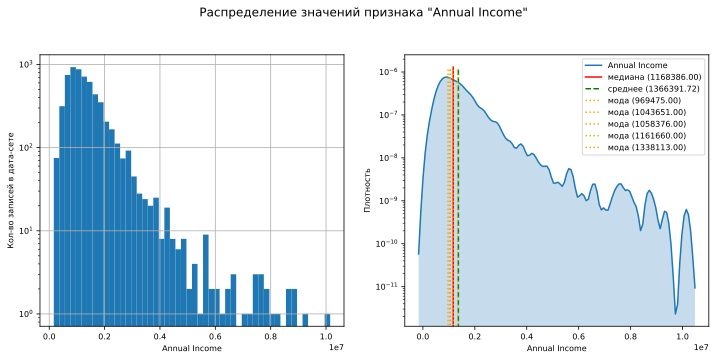

In [15]:
plot_hist_n_kde(df_train_prep_01['Annual Income'], 'Annual Income', y_log=True, mmm='111')

In [16]:
print(f"Минимальное значение: {df_train_prep_01['Annual Income'].min()}")
print(f"Максимальное значение: {df_train_prep_01['Annual Income'].max()}")

Минимальное значение: 164597.0
Максимальное значение: 10149344.0


На основании графиков можно сделать вывод, что, возможно, значения годового дохода в р-не 10 млн. являются аномальными. Зачем людям с таким годовым доходом кредитоваться? Посмотрим на цели кредитов:

In [17]:
df_train_prep_01.loc[df_train_prep_01['Annual Income'] > 9000000, 'Purpose']

2200         business loan
6472    debt consolidation
Name: Purpose, dtype: object

Цели кредитов - бизнес и, насколько понимаю, реструктуризация долгов. Т.е. это не бытовые нужды. Что, считаю, вполне логично для состоятельных заемщиков. Поэтому данные высокие значения годового дохода выбросами не считаю.

##### Обработка пропусков:

Кол-во пропущенных значений 'Annual Income' по целям кредита:

In [18]:
df_train_prep_01.loc[df_train_prep_01['Annual Income'].isnull(), 'Purpose'].value_counts()

debt consolidation      1214
other                    148
home improvements         96
business loan             23
buy a car                 19
medical bills             13
take a trip               10
major purchase            10
buy house                  8
small business             6
wedding                    3
vacation                   3
renewable energy           2
educational expenses       1
moving                     1
Name: Purpose, dtype: int64

Статистика по 'Annual Income' в зависимости от цели кредита:

In [19]:
statistics_on_feature(df_train_prep_01, 'Purpose', 'Annual Income')

Annual Income                                       
                              mean     median       min         max count
Purpose                                                                  
business loan         1.578203e+06  1254893.0  206017.0   9338880.0   106
buy a car             1.271642e+06   937137.0  226765.0   4473816.0    77
buy house             1.757871e+06  1314505.5  467039.0   7381842.0    26
debt consolidation    1.346966e+06  1165878.0  164597.0  10149344.0  4730
educational expenses  1.179417e+06   569943.0  201381.0   3752880.0     9
home improvements     1.640379e+06  1350301.5  233453.0   8758449.0   316
major purchase        1.347141e+06  1360466.5  244682.0   3793179.0    30
medical bills         1.601686e+06  1339443.0  191577.0   7660648.0    58
moving                1.012979e+06   775865.0  596163.0   2293908.0    10
other                 1.306160e+06  1133046.0  192223.0   6492395.0   517
renewable energy               NaN        NaN       NaN         NaN     0
small business        1.326634e+06  1081765.0  290415.0   4772800.0    20
take a trip           1.153258e+06   980685.0  199690.0   4667616.0    27
vacation              1.578060e+06  2013734.0  598576.0   2400631.0     5
wedding               2.095394e+06  1330693.5  730835.0   6620208.0    12

Для заполнения пропусков буду брать медианные значения, в зависимости от целей кредита:

In [20]:
fill_annual_income_nan(df_train_prep_01)

In [21]:
statistics_on_feature(df_train_prep_01, 'Purpose', 'Annual Income')

Annual Income                                        
                              mean     median        min         max count
Purpose                                                                   
business loan         1.520559e+06  1254893.0   206017.0   9338880.0   129
buy a car             1.205438e+06   937137.0   226765.0   4473816.0    96
buy house             1.653550e+06  1314505.5   467039.0   7381842.0    34
debt consolidation    1.309981e+06  1165878.0   164597.0  10149344.0  5944
educational expenses  1.118469e+06   569943.0   201381.0   3752880.0    10
home improvements     1.572788e+06  1350301.5   233453.0   8758449.0   412
major purchase        1.350472e+06  1360466.5   244682.0   3793179.0    40
medical bills         1.553670e+06  1339443.0   191577.0   7660648.0    71
moving                9.914235e+05   775865.0   596163.0   2293908.0    11
other                 1.267632e+06  1133046.0   192223.0   6492395.0   665
renewable energy      1.168386e+06  1168386.0  1168386.0   1168386.0     2
small business        1.270126e+06  1081765.0   290415.0   4772800.0    26
take a trip           1.106617e+06   980685.0   199690.0   4667616.0    37
vacation              1.741438e+06  2013734.0   598576.0   2400631.0     8
wedding               1.942454e+06  1330693.5   730835.0   6620208.0    15

Проверка - не осталось ли пропущенных значений:

In [22]:
len(df_train_prep_01.loc[df_train_prep_01['Annual Income'].isnull()])

0

Зависит ли вероятность дефолта по кредиту от годового дохода заемщика? Построим график:

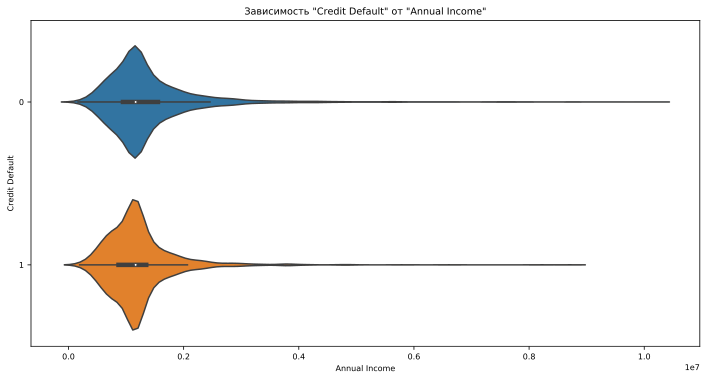

In [23]:
plot_violin_num(df_train_prep_01,'Annual Income','Credit Default')

Судя по графику, риску дефолта подвергнуты все категории заемщиков - вне зависимости от годового дохода.

#### 2. Проверка, корректировка "Tax Liens"

Так понимаю, это кол-во задолженностей по налогам.

In [24]:
df_train_prep_01['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [25]:
df_test['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

Кол-во вариантов значений данного признака в тренировочном и в тестовом дата-сетах невелико, но переводить данный признак в категориальный считаю неправильным. Аномальных значений нет. Оставляю все как есть.

#### 3. Проверка, корректировка "Number of Open Accounts"

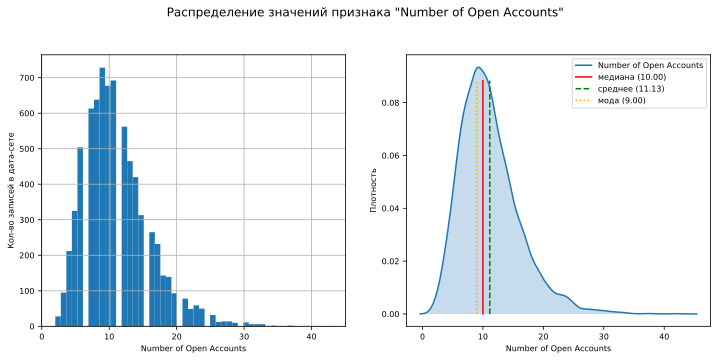

In [26]:
plot_hist_n_kde(df_train_prep_01['Number of Open Accounts'], 'Number of Open Accounts', mmm='111')

In [27]:
df_train_prep_01['Number of Open Accounts'].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

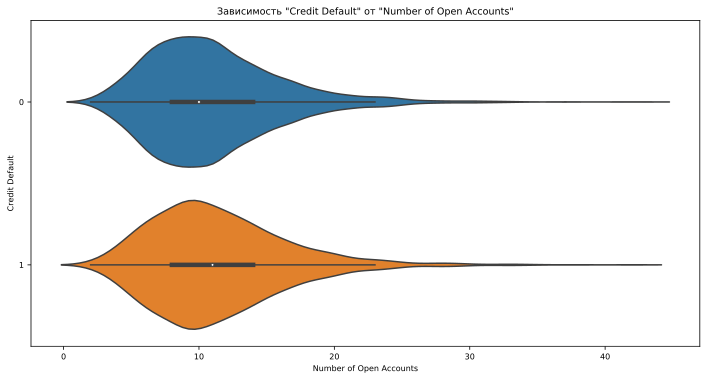

In [28]:
plot_violin_num(df_train_prep_01,'Number of Open Accounts','Credit Default')

Аномалий в значениях данного признака нет.

#### 4. Проверка, корректировка "Years of Credit History"

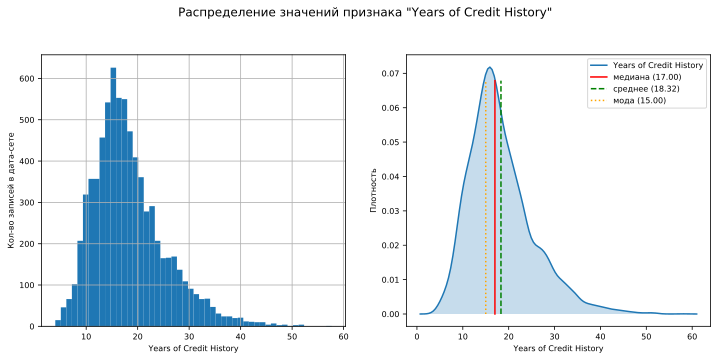

In [29]:
plot_hist_n_kde(df_train_prep_01['Years of Credit History'], 'Years of Credit History', mmm='111')

In [30]:
df_train_prep_01['Years of Credit History'].describe()

count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        57.700000
Name: Years of Credit History, dtype: float64

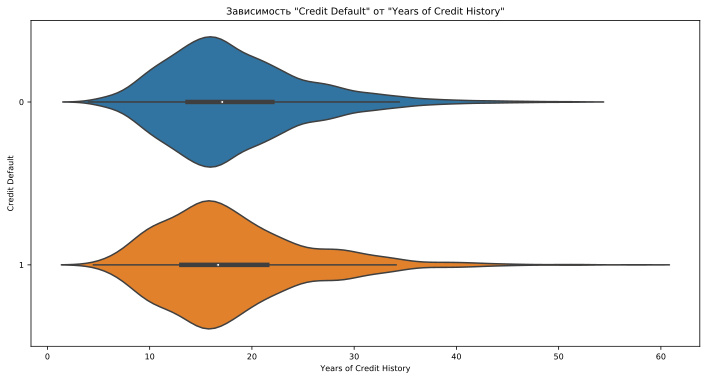

In [31]:
plot_violin_num(df_train_prep_01,'Years of Credit History','Credit Default')

Аномалий не видно. Риску дефолта подвержены заемщики с различной по длительности кредитной историей.

#### 5. Проверка, корректировка "Current Loan Amount"

Нарушу порядок анализа признаков - "очищенные" значения текущей суммы кредита понадобятся для обработки 'Maximum Open Credit'.

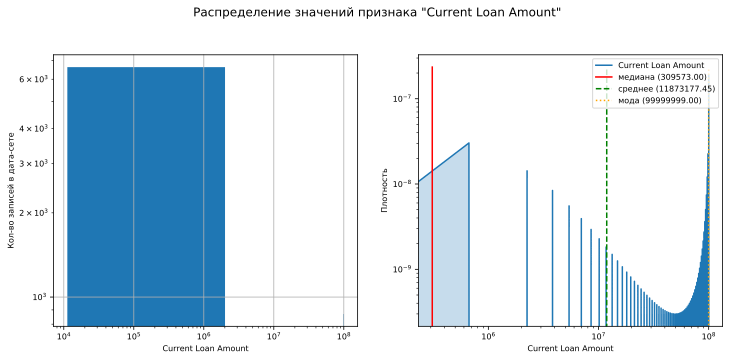

In [32]:
plot_hist_n_kde(df_train_prep_01['Current Loan Amount'], 'Current Loan Amount', x_log=True, y_log=True, mmm='111')

In [33]:
df_train_prep_01['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [34]:
df_train_prep_01['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

Максимальное значение, не считая 99999999:

In [35]:
df_train_prep_01.loc[df_train_prep_01['Current Loan Amount'] < 99999999,'Current Loan Amount'].max()

789030.0

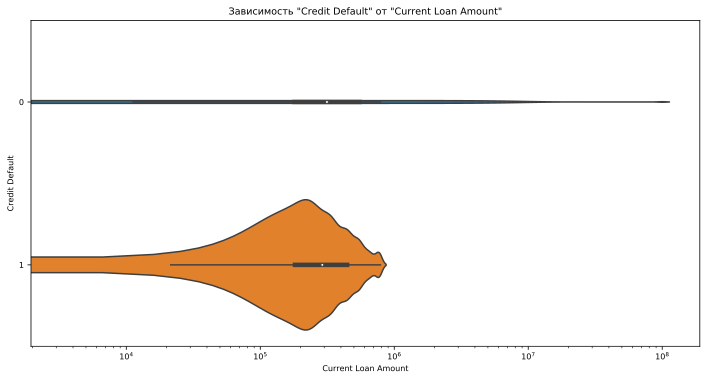

In [36]:
plot_violin_num(df_train_prep_01,'Current Loan Amount','Credit Default',x_log=True)

In [37]:
df_train_prep_01.loc[(df_train_prep_01['Current Loan Amount'] == 99999999)&(df_train_prep_01['Credit Default'] == 0),'Current Loan Amount'].count()

870

Значения 'Current Loan Amount', равные моде, определенно являются выбросами. Их почти 12% от общего числа значений. К тому же они на два порядка больше, чем предыдущее максимальное значение.

Заменю эти аномальные значения на медианное, полученное без учета этих выбросов. К тому же все аномальные значения 'Current Loan Amount' находятся только в тех записях дата-сета, значение целевого признака которых равно нулю (т.е. не дефолтные записи). Поэтому, предполагаю, замена выбросов на медианное значение не ухудшит модель классификации.

Но, как вариант, можно использовать медианные значения, полученные в зависимости от срока кредита, текущего кредитного баланса или годового дохода.

In [38]:
median_normal = df_train_prep_01.loc[df_train_prep_01['Current Loan Amount'] < 99999999,'Current Loan Amount'].median()
median_normal

265826.0

In [39]:
df_train_prep_01.loc[df_train_prep_01['Current Loan Amount'] == 99999999,'Current Loan Amount'] = median_normal

Посмотрим, что получилось:

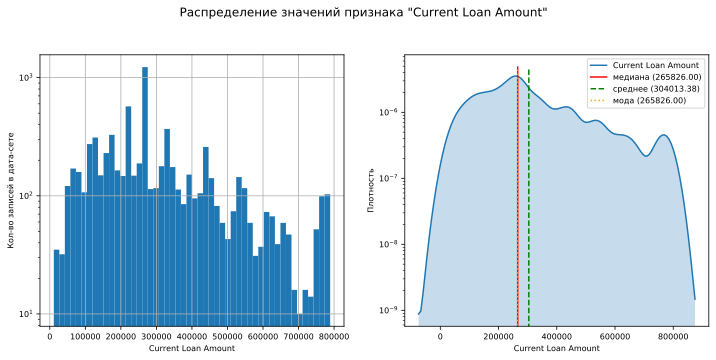

In [40]:
plot_hist_n_kde(df_train_prep_01['Current Loan Amount'], 'Current Loan Amount', y_log=True, mmm='111')

In [41]:
df_train_prep_01['Current Loan Amount'].describe()

count      7500.000000
mean     304013.377067
std      171951.057747
min       11242.000000
25%      180169.000000
50%      265826.000000
75%      396929.500000
max      789030.000000
Name: Current Loan Amount, dtype: float64

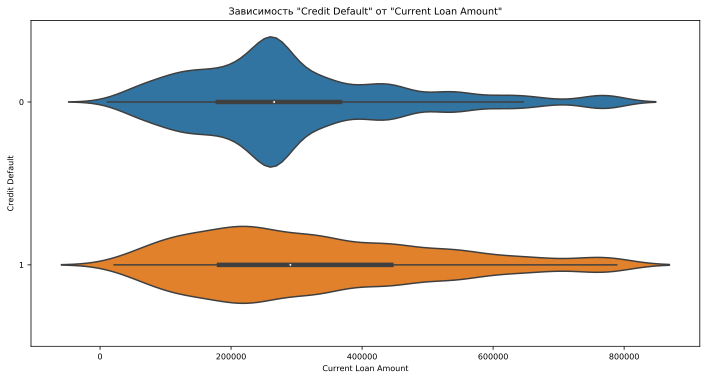

In [42]:
plot_violin_num(df_train_prep_01,'Current Loan Amount','Credit Default')

#### 6. Проверка, корректировка "Maximum Open Credit"

Так понимаю, это максимальный по сумме открытый кредит за все время кредитной истории.

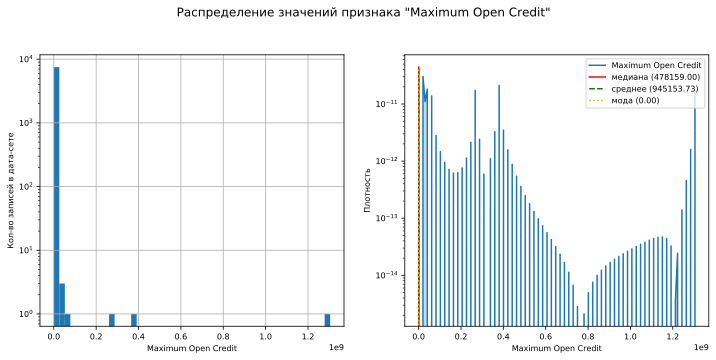

In [43]:
plot_hist_n_kde(df_train_prep_01['Maximum Open Credit'], 'Maximum Open Credit', y_log=True, mmm='111')

In [44]:
df_train_prep_01['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [45]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] == 0,'Maximum Open Credit'].count()

65

65 записей в датасете имеют значением данного признака 0. Может ли макисмальная сумма взятого кредита равняться нулю? Вряд ли. Посмотрим на текущую задолженность этих заемщиков:

In [46]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] == 0,'Current Loan Amount'].describe()

count        65.000000
mean     261298.400000
std      190367.188212
min       11242.000000
25%      112728.000000
50%      244684.000000
75%      301048.000000
max      760452.000000
Name: Current Loan Amount, dtype: float64

Ноль - это явно аномальное значение. Исправлю - сделаю равным текущей сумме кредита:

In [47]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] == 0,'Maximum Open Credit'] = df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] == 0,'Current Loan Amount']

Также есть аномально высокие значения:

In [48]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] > (10**7)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
354,Home Mortgage,2126537.0,10+ years,0.0,23.0,23.0,1.476048e+07,0.0,NaN,0.0,debt consolidation,Long Term,778624.0,1019806.0,40227.0,697.0,0
617,Home Mortgage,1165878.0,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
1476,Own Home,1165878.0,8 years,0.0,14.0,28.9,1.042866e+07,0.0,NaN,0.0,debt consolidation,Short Term,656766.0,1089802.0,16531.0,NaN,0
1879,Home Mortgage,1433835.0,6 years,0.0,8.0,17.8,1.270144e+07,0.0,35.0,0.0,debt consolidation,Short Term,197384.0,1985462.0,14099.0,749.0,0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0
2468,Home Mortgage,5589420.0,4 years,0.0,11.0,12.3,1.634591e+07,0.0,24.0,0.0,home improvements,Long Term,265826.0,2315169.0,74991.0,735.0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,265826.0,1908550.0,5770.0,743.0,0
3170,Home Mortgage,2226230.0,10+ years,0.0,20.0,19.0,1.868381e+07,0.0,NaN,0.0,buy a car,Short Term,111892.0,2355867.0,17123.0,750.0,0


Заменю их на соответствующие значения кредитного баланса:

In [49]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] > (10**7),'Maximum Open Credit'] = df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] > (10**7),'Current Credit Balance']

Посмотрим, что получилось:

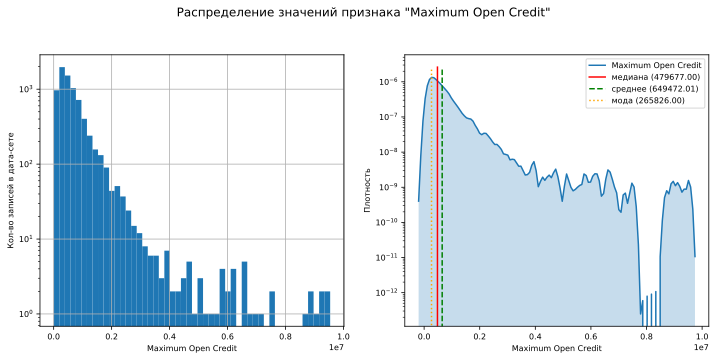

In [50]:
plot_hist_n_kde(df_train_prep_01['Maximum Open Credit'], 'Maximum Open Credit', y_log=True, mmm='111')

In [51]:
df_train_prep_01['Maximum Open Credit'].describe()

count    7.500000e+03
mean     6.494720e+05
std      6.799492e+05
min      4.334000e+03
25%      2.812150e+05
50%      4.796770e+05
75%      7.934300e+05
max      9.541136e+06
Name: Maximum Open Credit, dtype: float64

Возможно, все значения 'Maximum Open Credit' больше 8 млн. являются выбросами. Там их не так много осталось (см. ниже). Но оставлю пока так.

In [52]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] > (0.8*10**7)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
85,Home Mortgage,1301614.0,9 years,0.0,17.0,18.0,9339924.0,0.0,NaN,0.0,debt consolidation,Short Term,592240.0,959899.0,16813.0,748.0,0
2036,Home Mortgage,1172984.0,4 years,0.0,6.0,24.2,9094184.0,0.0,NaN,0.0,business loan,Long Term,335324.0,1413733.0,8709.0,748.0,0
2156,Home Mortgage,4044112.0,10+ years,0.0,22.0,26.5,8706038.0,0.0,NaN,0.0,home improvements,Short Term,265826.0,1037609.0,38082.0,751.0,0
2431,Own Home,1283279.0,NaN,0.0,17.0,31.4,8947840.0,0.0,26.0,0.0,debt consolidation,Short Term,350350.0,2024659.0,25880.0,747.0,0
4602,Home Mortgage,3990038.0,10+ years,0.0,10.0,23.0,9541136.0,0.0,5.0,0.0,home improvements,Long Term,788788.0,4367245.0,29792.0,687.0,0
5147,Home Mortgage,1432277.0,10+ years,0.0,6.0,29.2,9516540.0,0.0,NaN,0.0,home improvements,Short Term,265826.0,591755.0,3569.0,750.0,0
5974,Home Mortgage,3131865.0,10+ years,0.0,8.0,24.8,8903180.0,0.0,NaN,0.0,debt consolidation,Long Term,559636.0,2875726.0,22210.0,745.0,0
6265,Home Mortgage,1350301.5,10+ years,0.0,13.0,22.8,9167356.0,0.0,41.0,0.0,home improvements,Short Term,769384.0,2240594.0,69413.0,NaN,0


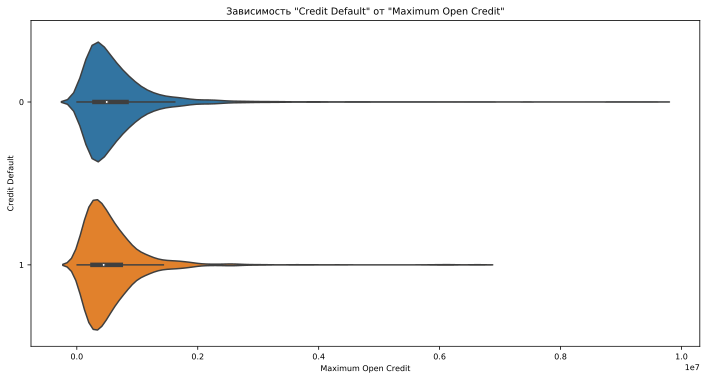

In [53]:
plot_violin_num(df_train_prep_01,'Maximum Open Credit','Credit Default')

#### 7. Проверка, корректировка "Number of Credit Problems"

In [54]:
df_train_prep_01['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [55]:
df_test['Number of Credit Problems'].value_counts()

0.0     2177
1.0      280
2.0       29
3.0        7
5.0        4
15.0       1
4.0        1
7.0        1
Name: Number of Credit Problems, dtype: int64

Данный признак переводить в категориальный не считаю правильным. Аномалий также нет.

#### 8. Проверка, корректировка "Months since last delinquent"

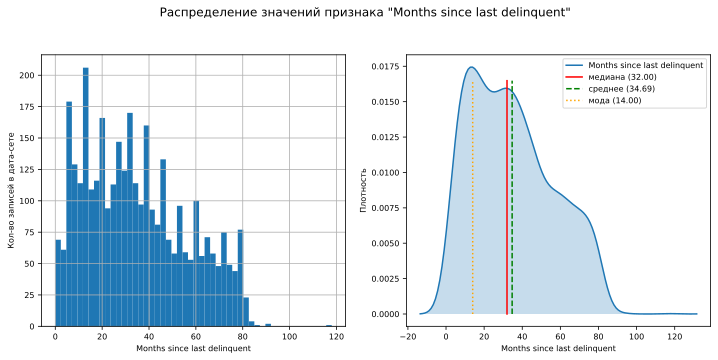

In [56]:
plot_hist_n_kde(df_train_prep_01['Months since last delinquent'], 'Months since last delinquent', mmm='111')

In [57]:
df_train_prep_01['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

Аномальных значений не наблюдаю. Единственное, очень много пропущенных значений. Заменю на моду.

Но, возможно, правильнее будет вообще не учитывать данный столбец при построении модели классификации.

In [58]:
df_train_prep_01.loc[df_train_prep_01['Months since last delinquent'].isnull(),'Months since last delinquent'] = df_train_prep_01['Months since last delinquent'].mode()[0]

#### 9. Проверка, корректировка "Bankruptcies"

In [59]:
df_train_prep_01['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [60]:
df_test['Bankruptcies'].value_counts()

0.0    2252
1.0     234
2.0       5
3.0       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64

In [61]:
df_train_prep_01['Bankruptcies'].count()

7486

Данный признак не следует переводить в разряд категориальных. Аномалий также нет. Для устранения пропусков использую моду:

In [62]:
df_train_prep_01['Bankruptcies'].fillna(0, inplace=True)

#### 10. Проверка, корректировка "Current Credit Balance"

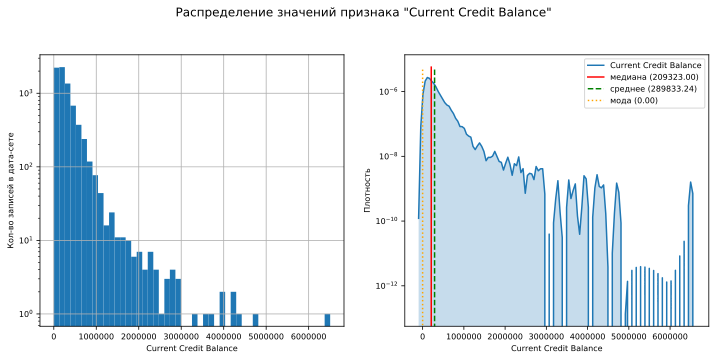

In [63]:
plot_hist_n_kde(df_train_prep_01['Current Credit Balance'], 'Current Credit Balance', y_log=True, mmm='111')

In [64]:
df_train_prep_01['Current Credit Balance'].value_counts().sort_index().head(20)

0.0       53
19.0       3
57.0       2
76.0       2
95.0       1
114.0      1
171.0      1
361.0      2
456.0      1
494.0      1
760.0      1
817.0      1
912.0      1
1102.0     1
1235.0     1
1368.0     2
1425.0     1
1444.0     1
1463.0     1
1482.0     1
Name: Current Credit Balance, dtype: int64

In [65]:
df_train_prep_01['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

Не считаю нулевые значения кредитного баланса выбросами (насколько понимаю этот термин). Максимальные значения также не сильно большие. Оставляю все как есть.

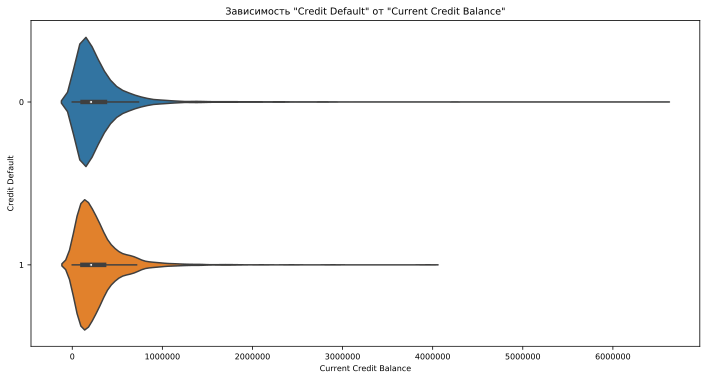

In [66]:
plot_violin_num(df_train_prep_01,'Current Credit Balance','Credit Default')

#### 11. Проверка, корректировка "Monthly Debt"

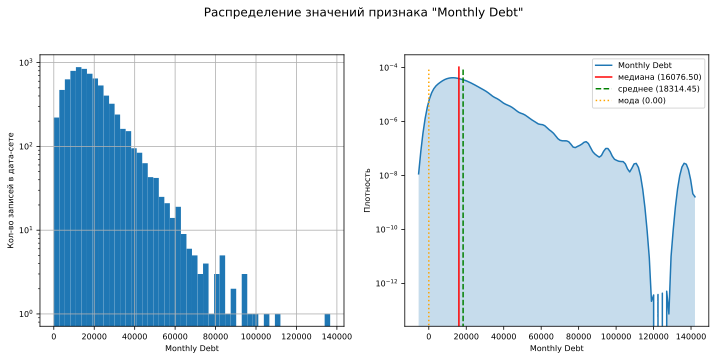

In [67]:
plot_hist_n_kde(df_train_prep_01['Monthly Debt'], 'Monthly Debt', y_log=True, mmm='111')

In [68]:
df_train_prep_01['Monthly Debt'].describe()

count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

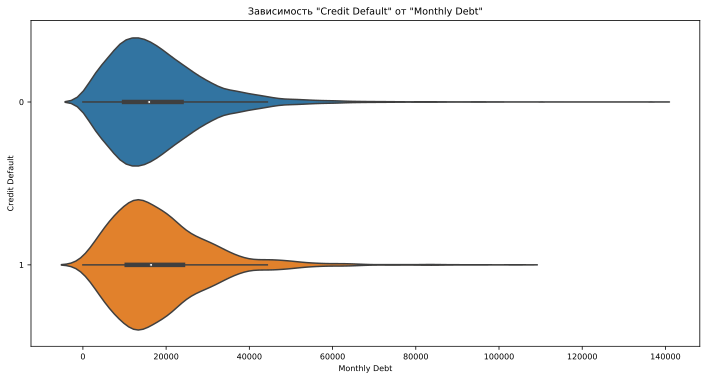

In [69]:
plot_violin_num(df_train_prep_01,'Monthly Debt','Credit Default')

Аномальных значений не наблюдается.

#### 12. Проверка, корректировка "Credit Score"

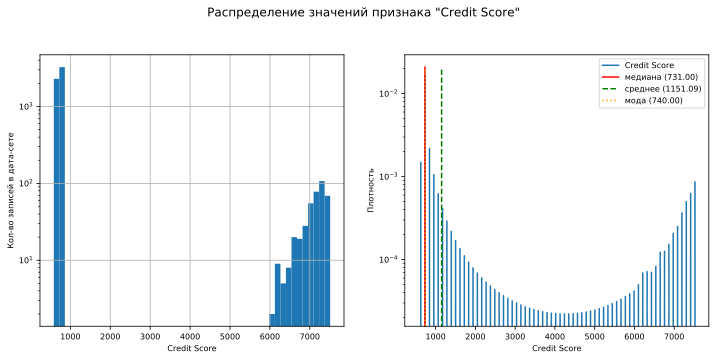

In [70]:
plot_hist_n_kde(df_train_prep_01['Credit Score'], 'Credit Score', y_log=True, mmm='111')

In [71]:
df_train_prep_01['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

Насколько я понимаю, значения кредитного рейтинга физлица должны лежать в диапазоне от 0 до 1000. Посмотрим на зависимость кредитного рейтинга от флага дефолта:

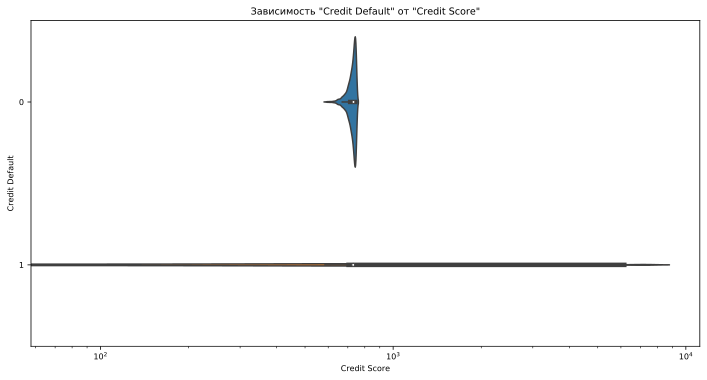

In [72]:
plot_violin_num(df_train_prep_01,'Credit Score','Credit Default',x_log=True)

Похоже, мое предположение верно.

Все пропуски можно заменить:
* при 'Credit Score' равном 0, на медиану;
* при 'Credit Score' равном 1, на 500 (условно плохой кредитный рейтинг);

Аномально большие значения заменим также на 500, т.к., судя по графику, аномальные значения присутствуют только в дефолтных записях.

In [73]:
median_normal =  df_train_prep_01.loc[df_train_prep_01['Credit Default'] == 0,'Credit Score'].median()
median_normal

732.0

In [74]:
df_train_prep_01.loc[df_train_prep_01['Credit Score'].isnull() & (df_train_prep_01['Credit Default'] == 0),'Credit Score'] = median_normal

In [75]:
df_train_prep_01.loc[df_train_prep_01['Credit Score'].isnull() & (df_train_prep_01['Credit Default'] == 1),'Credit Score'] = 500

In [76]:
df_train_prep_01.loc[df_train_prep_01['Credit Score'] > 1000,'Credit Score'] = 500

Проверим:

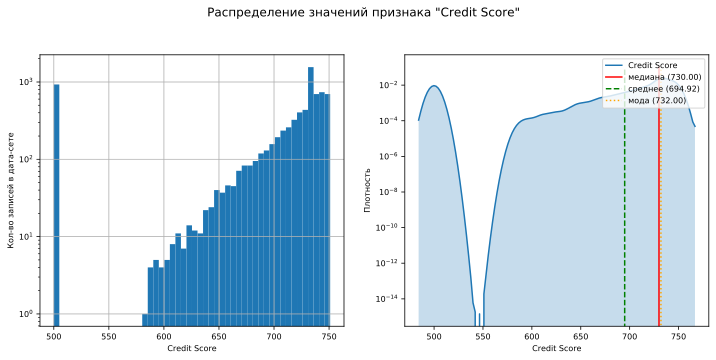

In [77]:
plot_hist_n_kde(df_train_prep_01['Credit Score'], 'Credit Score', y_log=True, mmm='111')

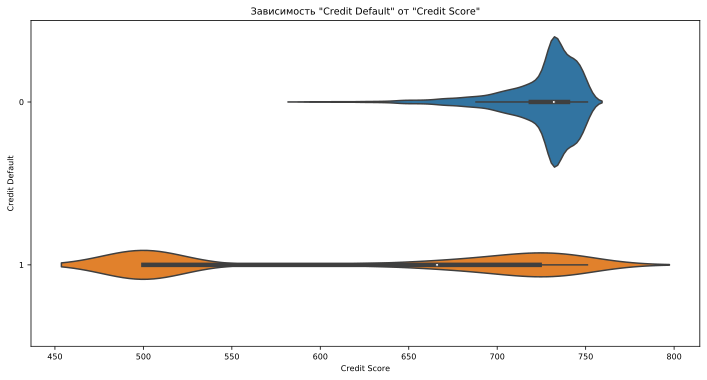

In [78]:
plot_violin_num(df_train_prep_01,'Credit Score','Credit Default')

Подменное значение (500) можно будет варьировать в различных вариантах обучения модели.

#### 13. Проверка, корректировка "Credit Default"

In [79]:
df_train_prep_01['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Со значениями целевого признака порядок.

### *Анализ категориальных переменных*

In [80]:
df_train_prep_01.select_dtypes(include=np.object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Home Ownership        7500 non-null   object
 1   Years in current job  7129 non-null   object
 2   Purpose               7500 non-null   object
 3   Term                  7500 non-null   object
dtypes: object(4)
memory usage: 234.5+ KB


In [81]:
for column in df_train_prep_01.select_dtypes(include=['object']).columns:
    print('\n' + '*'*100)
    print(f'\n\t"{column}":')
    print(f'\nТренировочный:\n\n{df_train_prep_01[column].value_counts()}')
    print(f'\nТестовый:\n\n{df_test[column].value_counts()}')


****************************************************************************************************

	"Home Ownership":

Тренировочный:

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Тестовый:

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64

****************************************************************************************************

	"Years in current job":

Тренировочный:

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Тестовый:

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in curre

Аномальных значений в категориальных переменных не наблюдаю. Единственное:
* В "Years in current job" (тренировочные данные) необходимо заполнить пропуски.
* В "Purpose", в тестовом дата-сете, отсутствует значение "renewable energy". В тренировочном дата-сете также нужно будет исключить это значение.

#### 1. Корректировка "Years in current job"

Пропусков не очень много, заполню модой:

In [82]:
df_train_prep_01['Years in current job'].fillna('10+ years',inplace=True)

#### 2. Корректировка "Purpose"

In [83]:
df_train_prep_01[df_train_prep_01['Purpose'] == 'renewable energy']

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
2223,Home Mortgage,1168386.0,10+ years,0.0,3.0,22.6,295218.0,0.0,14.0,0.0,renewable energy,Long Term,215468.0,198341.0,6421.0,500.0,1
7082,Own Home,1168386.0,3 years,0.0,14.0,27.9,182094.0,0.0,25.0,0.0,renewable energy,Short Term,21912.0,49533.0,9878.0,500.0,1


В дата-сете всего две записи, где цель кредита укзана как "возобновляемая энергия". Использую моду для замены:

In [84]:
df_train_prep_01.loc[df_train_prep_01['Purpose'] == 'renewable energy', 'Purpose'] = 'debt consolidation'

### *Преобразование категориальных переменных в группы бинарных*

In [85]:
columns_obj = df_train_prep_01.select_dtypes(include=np.object).columns.to_list()
columns_obj

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [86]:
df_train_prep_02 = pd.concat([df_train_prep_01,pd.get_dummies(df_train_prep_01,prefix_sep=' --- ',columns=columns_obj)], axis=1)

Итоговый тренировочный дата-сет:

In [87]:
df_train_prep_02

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Ownership --- Have Mortgage,Home Ownership --- Home Mortgage,Home Ownership --- Own Home,Home Ownership --- Rent,Years in current job --- 1 year,Years in current job --- 10+ years,Years in current job --- 2 years,Years in current job --- 3 years,Years in current job --- 4 years,Years in current job --- 5 years,Years in current job --- 6 years,Years in current job --- 7 years,Years in current job --- 8 years,Years in current job --- 9 years,Years in current job --- < 1 year,Purpose --- business loan,Purpose --- buy a car,Purpose --- buy house,Purpose --- debt consolidation,Purpose --- educational expenses,Purpose --- home improvements,Purpose --- major purchase,Purpose --- medical bills,Purpose --- moving,Purpose --- other,Purpose --- small business,Purpose --- take a trip,Purpose --- vacation,Purpose --- wedding,Term --- Long Term,Term --- Short Term
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,14.0,1.0,debt consolidation,Short Term,265826.0,47386.0,7914.0,749.0,0,482087.0,0.0,11.0,26.3,685960.0,1.0,14.0,1.0,265826.0,47386.0,7914.0,749.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,14.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,14.0,0.0,264968.0,394972.0,18373.0,737.0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,14.0,0.0,debt consolidation,Short Term,265826.0,308389.0,13651.0,742.0,0,751412.0,0.0,11.0,35.0,1182434.0,0.0,14.0,0.0,265826.0,308389.0,13651.0,742.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,14.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,805068.0,0.0,8.0,22.5,147400.0,1.0,14.0,1.0,121396.0,95855.0,11338.0,694.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,14.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,776264.0,0.0,13.0,13.6,385836.0,1.0,14.0,0.0,125840.0,93309.0,7180.0,719.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,14.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0,402192.0,0.0,3.0,8.5,107866.0,0.0,14.0,0.0,129360.0,73492.0,1900.0,697.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,500.0,1,1533984.0,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,444048.0,456399.0,12783.0,500.0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,14.0,0.0,buy a car,Short Term,265826.0,477812.0,12479.0,748.0,0,1878910.0,0.0,12.0,32.1,1778920.0,0.0,14.0,0.0,265826.0,477812.0,12479.0,748.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7498,Home Mortgage,1165878.0,10+ years,0.0,21.0,26.5,1141250.0,0.0,14.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,732.0,0,1165878.0,0.0,21.0,26.5,1141250.0,0.0,14.0,0.0,615274.0,476064.0,37118.0,73